In [1]:
!pip install segmentation-models-pytorch --quiet
!pip install albumentations --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.4 MB/s eta 0:00:0000:01


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import segmentation_models_pytorch as smp
from torchmetrics.classification import BinaryJaccardIndex
import albumentations as A
from albumentations.pytorch import ToTensorV2
!pip install -U albumentations --quiet

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 17.8 MB/s eta 0:00:00


In [3]:
IMAGE_DIR = "/kaggle/input/tumor-data/dataset/images"
MASK_DIR = "/kaggle/input/tumor-data/dataset/masks"

image_files = sorted([os.path.join(IMAGE_DIR, file) for file in os.listdir(IMAGE_DIR)])
mask_files = sorted([os.path.join(MASK_DIR, file) for file in os.listdir(MASK_DIR)])

In [4]:
def standardize_to_grayscale(image):
    # If image is already grayscale (2D), add channel dimension and return
    if len(image.shape) == 2:
        return np.expand_dims(image, axis=-1)
    
    # If image is RGB, convert to grayscale
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return np.expand_dims(gray, axis=-1)
    
    # If image is already grayscale with channel dimension
    if len(image.shape) == 3 and image.shape[2] == 1:
        return image
        
    raise ValueError(f"Unexpected image format with shape {image.shape}")


transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

class BrainMRIDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Read image without explicitly specifying grayscale
        img = cv2.imread(self.images[idx])
        if img is None:
            raise ValueError(f"Failed to load image: {self.images[idx]}")
            
        # Convert to grayscale if needed and ensure channel dimension
        img = standardize_to_grayscale(img)
        
        # Read and process mask
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError(f"Failed to load mask: {self.masks[idx]}")
            
        mask = (mask // 255).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        # if mask dimension does not match with the image after standardize_to_grayscale()
        if len(mask.shape) == 2:
            mask = mask.unsqueeze(0)

        return img, mask

In [5]:
train_images, val_images, train_masks, val_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)
val_images, test_images, val_masks, test_masks = train_test_split(
    val_images, val_masks, test_size=0.5, random_state=42
)


train_dataset = BrainMRIDataset(train_images, train_masks, transform=transform)
val_dataset = BrainMRIDataset(val_images, val_masks, transform=transform)
test_dataset = BrainMRIDataset(test_images, test_masks, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet34",  #backbone
    encoder_weights="imagenet",  # using pretrained weights
    in_channels=1,  # Input channels (grayscale)
    classes=1,  # *binary* segmentation
)


class DiceLoss(nn.Module):
    def __init__(self, smooth=0.0001):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)  # to ensure predictions are between 0 and 1
        preds = preds.view(-1)
        targets = targets.view(-1)
        
        intersection = (preds * targets).sum()
        dice = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        
        return 1 - dice


dice = DiceLoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 133MB/s] 


running...
Using 2 GPUs
Epoch 1, Loss: 1.3118088341722585
Epoch 2, Loss: 0.9877078834206167
Epoch 3, Loss: 0.8154368846103398
Epoch 4, Loss: 0.6534651322196229
Epoch 5, Loss: 0.48898387467018284
Epoch 6, Loss: 0.38289310896035395
Epoch 7, Loss: 0.3197992727009937
Epoch 8, Loss: 0.2685229942353085
Epoch 9, Loss: 0.2400790982776218
Epoch 10, Loss: 0.2119321728294546
Epoch 11, Loss: 0.19955506341324913
Epoch 12, Loss: 0.1890147506739154
Epoch 13, Loss: 0.1857119763288835
Epoch 14, Loss: 0.17308751282968907
Epoch 15, Loss: 0.1705402551275311
Epoch 16, Loss: 0.1672784537829534
Epoch 17, Loss: 0.15614937908119625
Epoch 18, Loss: 0.14651905120623232
Epoch 19, Loss: 0.15064213041103247
Epoch 20, Loss: 0.14841657440469722
Epoch 21, Loss: 0.14616381866161268
Epoch 22, Loss: 0.13183210045099258
Epoch 23, Loss: 0.13391724469685795
Epoch 24, Loss: 0.127491957837283
Epoch 25, Loss: 0.12241391100064673


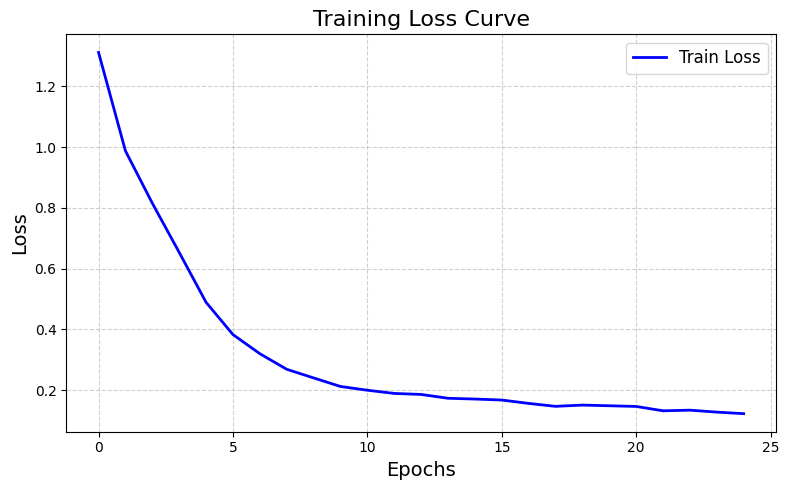

In [7]:
print("running...") #to be sure it started executing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)
model = model.to(device)


num_epochs = 25
train_losses = []

for epoch in range(num_epochs):
    
    model.train()
    
    train_loss = 0.0
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss_bce = criterion(outputs, masks)
        loss_dice = dice(outputs, masks)
        
        loss = loss_bce + loss_dice  # combining them for more stability
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader)}")


#ploting training loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training Loss Curve', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [8]:
print("running...")

def evaluate_model(loader, model, device):
    model.eval()
    metric = BinaryJaccardIndex().to(device)
    
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs)  # Get probabilities
            
            # Update the running IoU score
            # BinaryJaccardIndex expects probabilities, not binary predictions
            metric.update(preds, masks)
    
    # Compute the final IoU score
    final_iou = metric.compute().item()
    metric.reset()  # Reset for next evaluation
    return final_iou

# Train IoU
train_iou = evaluate_model(train_loader, model, device)
print(f"Train IoU: {train_iou:.4f}")

# Validation IoU
val_iou = evaluate_model(val_loader, model, device)
print(f"Validation IoU: {val_iou:.4f}")

# Test IoU
test_iou = evaluate_model(test_loader, model, device)
print(f"Test IoU: {test_iou:.4f}")

running...
Train IoU: 0.8272
Validation IoU: 0.7828
Test IoU: 0.7596


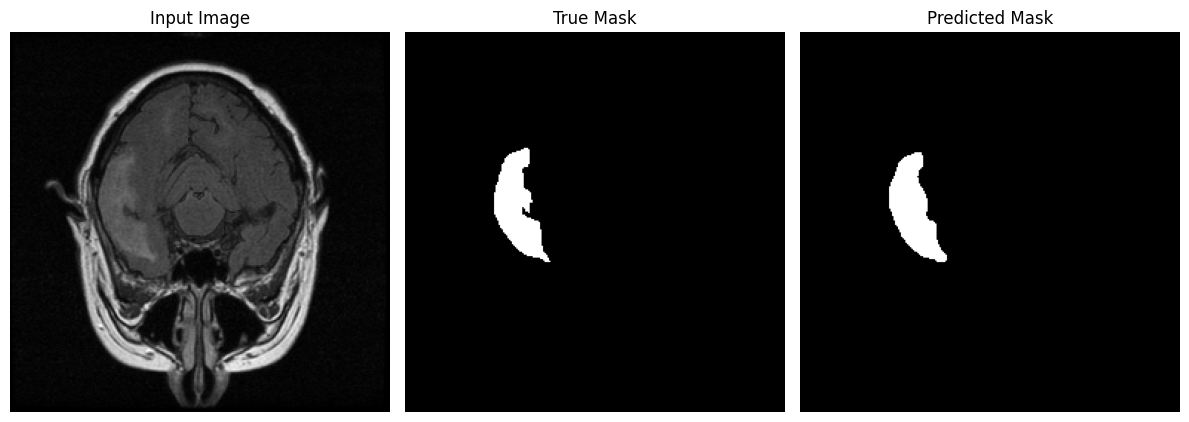

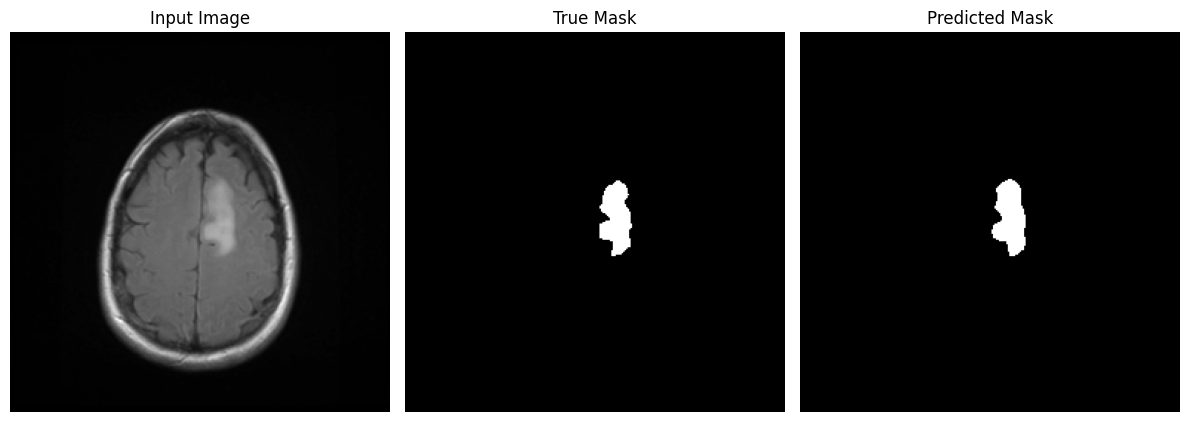

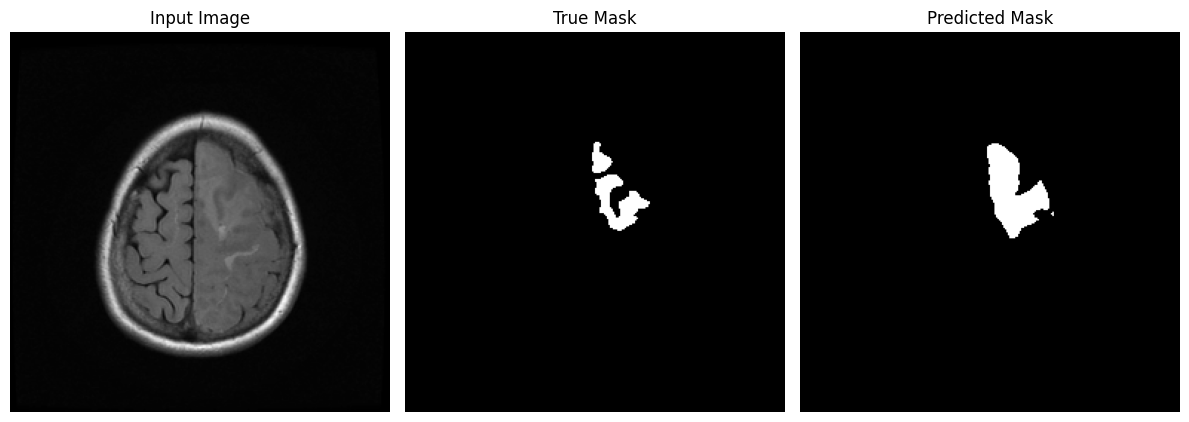

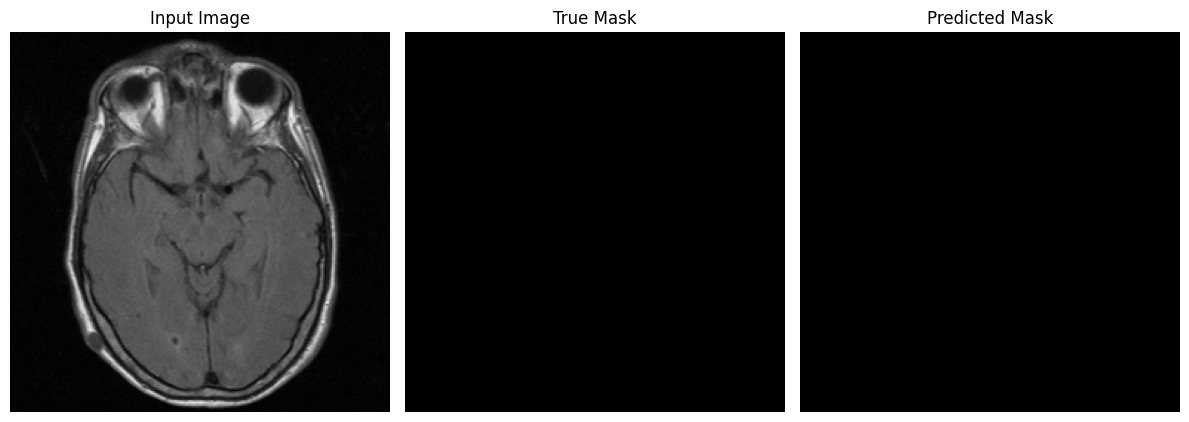

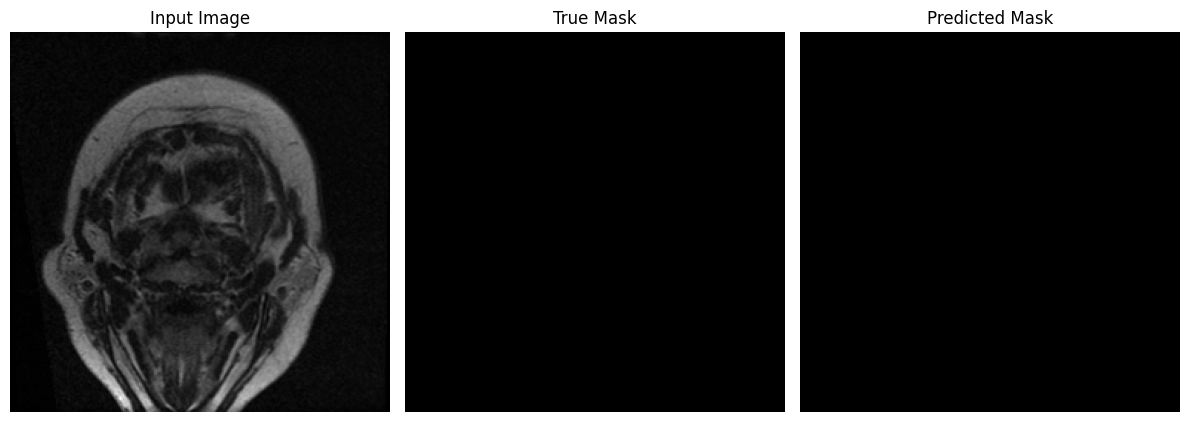

In [9]:
def visualize_predictions(model, dataset, device, num_samples=5):
    
    model.eval()

    for i in range(num_samples):
        img, mask = dataset[i+4]
        img = img.unsqueeze(0).to(device)  # Add batch dimension

        with torch.no_grad():
            pred = torch.sigmoid(model(img)) > 0.5  # Apply sigmoid and threshold

        # Convert tensors to numpy arrays for visualization
        img_np = img.cpu().squeeze().numpy()
        mask_np = mask.cpu().squeeze().numpy()
        pred_np = pred.cpu().squeeze().numpy()

        # Plot input image, true mask, and predicted mask
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(img_np, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(mask_np, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_np, cmap="gray")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


visualize_predictions(model, test_dataset, device=device)
